# Data assimilation

## Elfi package and ABC rejection algorithm

In [10]:
import time
import elfi
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

%matplotlib inline
%precision 2
seed = 20170530 
np.random.seed(seed)

In [11]:
# We set true parameters
a = 9
b = 5


In [12]:
# We define start, stop and sampling for the function
start = 0
stop = 100
sampling = 0.1
number_of_samples = int(1/sampling)

full_range = np.arange(start, stop, sampling)
all_x_range = np.array(full_range).reshape((1, len(full_range)))

# we define starting and ending points, so assuming they are 0 - 20 and sampling is 0.01 we have 2000 points
# 0, 0.01, 0.02 ... etc
first_x_range_start, first_x_range_stop = (0, 20)
second_x_range_start, second_x_range_stop = (20, 40)
third_x_range_start, third_x_range_stop = (40, 60)

# 0, 0.01, 0.02 .... 19.99
first_x_data = full_range[first_x_range_start*number_of_samples : first_x_range_stop*number_of_samples]
first_x_data = np.array(first_x_data).reshape((1, len(first_x_data)))

# 20.00, 20.01, 20.02 .... 39.99
second_x_data = full_range[second_x_range_start*number_of_samples : second_x_range_stop*number_of_samples]
second_x_data = np.array(second_x_data).reshape((1, len(second_x_data)))

# 40.00, 40.01, 40.02 .... 59.99
third_x_data = full_range[third_x_range_start*number_of_samples:third_x_range_stop*number_of_samples]
third_x_data = np.array(third_x_data).reshape((1, len(third_x_data)))


In [13]:
# This calculates y values for given range of x arguments
def calculate_model(a, b, data):
    """Function needed to calculate y values based on passed data as x arguments"""
    a = np.asanyarray(a).reshape((-1, 1))
    b = np.asanyarray(b).reshape((-1, 1))
    
    x = (np.sin((2*np.pi*a*data[:, 0:])/(23*b)) + 
         np.sin((2*np.pi*a*data[:, 0:])/28) + 
         np.sin((2*np.pi*a*data[:, 0:])/33) ) * np.log(a*data[:, 0:])
#     x =  np.log(a*data[:, 0:]) * np.sin(data[:, 0:])
    
    return x

 /srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning:divide by zero encountered in log
 /srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning:invalid value encountered in multiply


Text(0, 0.5, 'Y value of the model')

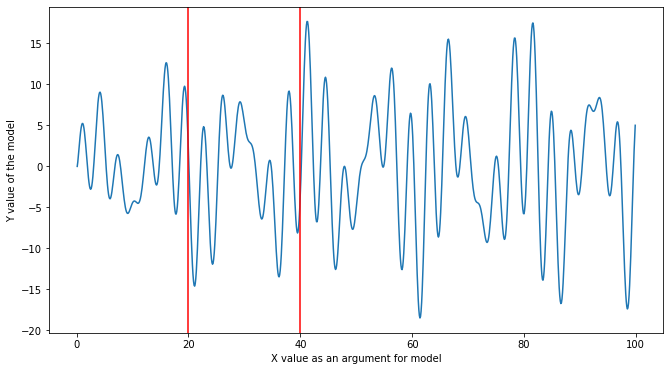

In [14]:
# Plot the observed sequence for whole range
y_obs = calculate_model(a, b, all_x_range)
plt.figure(figsize=(11, 6));

plt.plot(all_x_range[0, :], y_obs[0, :]);

# Points between these lines are training points
plt.axvline(x=second_x_range_start, color='r')
plt.axvline(x=second_x_range_stop,  color='r')

plt.xlabel('X value as an argument for model')
plt.ylabel('Y value of the model')

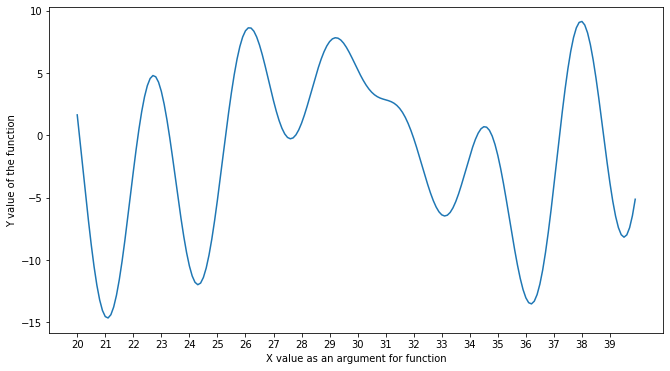

In [15]:
# We plot only training part

train_data = calculate_model(a, b, second_x_data)
plt.figure(figsize=(11, 6));

plt.xticks(np.arange(second_x_range_start, second_x_range_stop, 1.0))

plt.plot(second_x_data[0, :], train_data[0, :])
plt.xlabel('X value as an argument for function')
plt.ylabel('Y value of the function')
plt.show()

In [16]:
# This is actual function which is passed to ELFI algorithm, it fullfills interface contract 
# first parameters (a,b,... or more) are model parameters
def model(a, b, batch_size=1, random_state=None):
    """Function needed to calculate y values based on passed data as x arguments"""
    a = np.asanyarray(a).reshape((-1, 1))
    b = np.asanyarray(b).reshape((-1, 1))
    
    # second_x_data are train data, they are globally defined so they are accessible here
    x = (np.sin((2*np.pi*a*second_x_data[:, 0:])/(23*b)) + 
         np.sin((2*np.pi*a*second_x_data[:, 0:])/28) + 
         np.sin((2*np.pi*a*second_x_data[:, 0:])/33) ) * np.log(a*second_x_data[:, 0:])
    x = np.log(a*second_x_data[:, 0:]) 
    
    return x

In [17]:
# This parameter makes range for input parameters
# (a-width, 2 * width) ---> from a-width to a + width
width = 4

a_param = elfi.Prior(scipy.stats.uniform, a-width, 2 * width)
b_param = elfi.Prior(scipy.stats.uniform, b-width, 2 * width)

#Define the simulator node with the MA2 model ,give the priors to it as arguments.
Y = elfi.Simulator(model, a_param, b_param, observed=train_data)

# Autocovariances as the summary statistics
def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    return C

In [18]:
#Summary node is defined by giving the autocovariance function and the simulated data (also includes observed data)
S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)

#Calculating the squared distance (S1_sim-S1_obs)**2 + (S2_sim-S2_obs)**2
d = elfi.Distance('euclidean', S1, S2)


#Inference with rejection sampling
#batch_size defines how many simulations are performed in each passing through the graph
batch_size = 1000

# Instatiation of the Rejection Algorithm
rej = elfi.Rejection(d, batch_size=batch_size, seed=seed)

N = 1000
%time result = rej.sample(N, quantile=0.001)
#Print sampled means of parameters

print(result)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
CPU times: user 24.3 s, sys: 133 ms, total: 24.4 s
Wall time: 25.1 s
Method: Rejection
Number of samples: 1000
Number of simulations: 1000000
Threshold: 11.2
Sample means: _prior_4943: 13, _prior_cace: 5.12, a_param: 9.08, b_param: 5



In [19]:
#Final result of mean samples
b_result_last = result.samples['b_param'].mean()
a_result_last = result.samples['a_param'].mean()

print(a_result_last)
print(b_result_last)

9.083990895776738
4.998837946602926


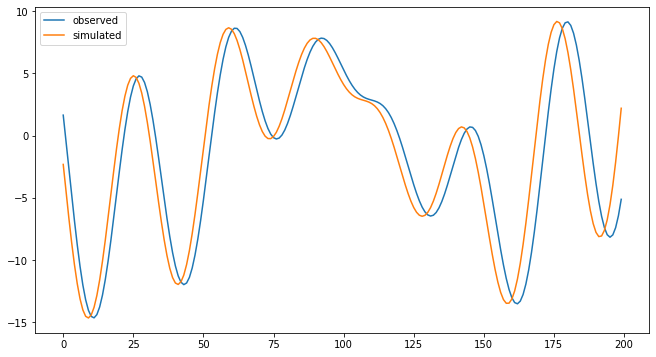

In [20]:
y_obs = calculate_model(a, b, second_x_data)

plt.figure(figsize=(11, 6))

plt.plot(y_obs.ravel(),label="observed")

plt.plot(calculate_model(a_result_last, b_result_last, second_x_data).ravel(), label="simulated")

plt.legend(loc="upper left")

plt.show()

 /srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning:divide by zero encountered in log
 /srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning:invalid value encountered in multiply
No handles with labels found to put in legend.


<Figure size 792x432 with 0 Axes>

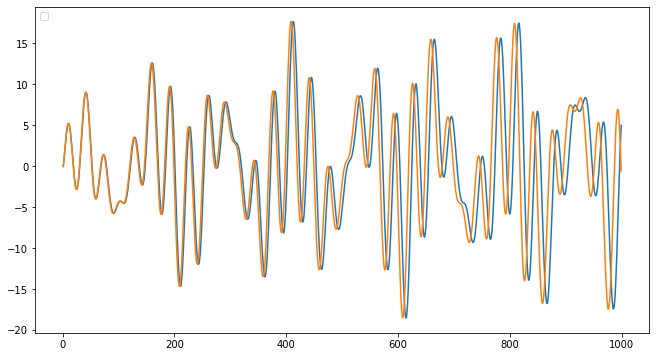

In [21]:
#Comparing observed data with simulated data on posterior parmeters (on whole data set)

plt.figure(figsize=(11, 6));

y_obs = calculate_model(a, b, all_x_range)

plt.figure(figsize=(11, 6));

plt.plot(y_obs.ravel());

all_results_predicted = calculate_model(a_result_last, b_result_last, all_x_range)

plt.plot(all_results_predicted.ravel());

plt.legend(loc="upper left")

plt.show()

In [ ]:
def calculate_error(start, stop):
    calculate = 0
    for i in range(start, stop, 1):
        calculate += (y_obs[0][i] - allq[0][i])**2
    return calculate
    

In [ ]:
calculate_error(100, 148)

In [ ]:
calculate_error(0, 49)